In [1]:
import pathlib
base_path = pathlib.Path("../")

In [2]:
import torch
from torchvision import transforms
import numpy as np
import json
import sys
sys.path.append(str(base_path))
from src.models.v1.model import AudioAutoEncoder
from src.models.v1.training import train_autoencoder
from src.dataloaders.v1.dataloader import AudioDB
from src.utils.utils import plot_loss_functions

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [3]:

data_path = base_path / 'audio/'
results_path = base_path / 'results/'
models_path = base_path / 'models/'

In [4]:
# Checking if gpu available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define model to resume training

In [5]:
# CHANGE ME!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model_timestamp = "09-12-2022_21-53"
epoch = 15

# DON'T CHANGE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model_name = f"{model_timestamp}/model"
model_checkpoint_basename = models_path / f"{model_name}__epoch_{epoch}"
model_checkpoint_epoch = pathlib.Path(f"{model_checkpoint_basename}.ckpt")
model_loss_filename = pathlib.Path(f"{model_checkpoint_basename}_loss.npy")
model_loss_test_filename = pathlib.Path(f"{model_checkpoint_basename}_loss_testing.npy")
model_hyperparams_filename = models_path / model_timestamp / "hyperparams.json"

with open(model_hyperparams_filename, "r") as f:
    model_hyperparams_dict = json.load(f)
autoencoder = AudioAutoEncoder(2, 32, 400)

In [6]:
assert model_checkpoint_epoch.exists()
assert model_loss_filename.exists()
assert model_loss_test_filename.exists()
assert model_hyperparams_filename.exists()

## Load model

In [7]:
trained_model_dict = torch.load(model_checkpoint_epoch)

autoencoder.load_state_dict(trained_model_dict)
autoencoder = autoencoder.to(device)

In [8]:
model_hyperparams_dict

{'learning_rate': 0.001,
 'weight_decay': 1e-05,
 'optimizer': "<class 'torch.optim.adam.Adam'>",
 'lambda': 0.5,
 'target_num_epochs': 30}

In [9]:
#Initialize indepdent optimizer for both networks
learning_rate = model_hyperparams_dict["learning_rate"]
weight_decay = model_hyperparams_dict["weight_decay"]
optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr=learning_rate, 
                             weight_decay=weight_decay)
lbmda = model_hyperparams_dict["lambda"]

num_epochs = model_hyperparams_dict["target_num_epochs"]

## Load loss history

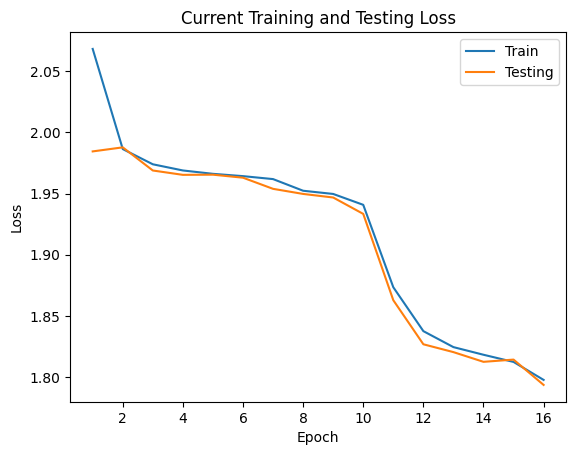

In [10]:
losses_list = list(np.load(model_loss_filename))
losses_list_testing = list(np.load(model_loss_test_filename))

plot_loss_functions([losses_list, losses_list_testing],
                    ["Train", "Testing"],
                    "Current Training and Testing Loss")

# Dataloader

## Train dataloader

In [11]:
# DataLoader
tr = transforms.Compose([
        transforms.ToTensor(), 
        ])

data_filename = data_path / "train_data.csv"

batch_size = 60
train_audios_db = AudioDB(data_filename,
                   data_path,
                   tr)

num_workers = 8

train_loader = torch.utils.data.DataLoader(dataset=train_audios_db,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers = num_workers)

## Testing dataloader

In [12]:
# DataLoader
data_filename = data_path / "test_data.csv"

test_audios_db = AudioDB(data_filename,
                   data_path,
                   tr)

test_loader = torch.utils.data.DataLoader(dataset=test_audios_db,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers = num_workers)

# Resume training

In [ ]:
model_filename, model_loss_filename, losses_list, losses_list_testing = train_autoencoder(autoencoder,
                                                                                          train_loader,
                                                                                          test_loader, 
                                                                                          optimizer,
                                                                                          model_name,
                                                                                          models_path,
                                                                                          num_epochs,
                                                                                          device,
                                                                                          lbmda,
                                                                                          losses_list,
                                                                                          losses_list_testing,
                                                                                          epoch_start=epoch+1)

# Plot loss after training

In [ ]:
plot_loss_functions([losses_list, losses_list_testing],
                    ["Train", "Testing"],
                    "Current Training and Testing Loss")